In [46]:
# This model will attempt to build a regression model for ethereum prices using LSTM. We will evluated it using regression evluation metrics.

# Import libraries and dependencies

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
data = yf.download(tickers = 'ETH-USD', start = '2012-03-11',end = '2023-04-13')
data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-04-08,1864.679077,1879.107788,1848.875488,1849.498169,1849.498169,5016362733
2023-04-09,1849.672241,1873.057373,1828.700073,1859.387817,1859.387817,6361497715
2023-04-10,1859.741211,1917.300171,1848.164185,1911.207520,1911.207520,8380134275
2023-04-11,1911.375854,1936.728271,1886.534180,1892.189697,1892.189697,8877222956
2023-04-12,1891.949707,1929.881226,1860.036865,1920.682129,1920.682129,11010714187


In [47]:
# Adding indicators, including relative strength and exponential moving averages
data['RSI']=ta.rsi(data.Close, length=15)



data.dropna(inplace=True)
data.drop(['Volume', 'Close'], axis=1, inplace=True)
df=pd.DataFrame(data)
df.head()

,Open,High,Low,Adj Close,RSI
Date,,,,,
2017-11-24,412.501007,480.972992,402.757996,474.911011,88.615862
2017-11-25,475.675995,485.191986,461.053009,466.276001,84.190405
2017-11-26,465.973999,472.722992,451.605988,471.329987,84.670481
2017-11-27,471.531006,493.404999,468.484985,480.355011,85.512203
2017-11-28,480.518005,482.480011,466.346985,472.902008,81.550229


In [48]:
def window_data(data, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)


In the forthcoming activities, we will predict buy or sell using a `5` days windows of previous eth target class data, so that, we will create the `X` and `y` vectors by calling the `window_data` function and defining a window size of `5` and setting the features and target column numbers to `7` (this is the column with the target class data).

In [49]:
# Creating the features (X) and target (y) data using the window_data() function. 
window_size = 5

feature_column = 3
target_column = 3
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[20:]}")

X sample values:
[[474.91101074 466.27600098 471.32998657 480.35501099 472.90200806]
 [466.27600098 471.32998657 480.35501099 472.90200806 427.52301025]
 [471.32998657 480.35501099 472.90200806 427.52301025 447.11401367]] 

y sample values:
[[ 826.82299805]
 [ 819.08599854]
 [ 821.06298828]
 ...
 [1911.20751953]
 [1892.18969727]
 [1920.68212891]]


In [50]:
# split data
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [51]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [52]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.09563299]
  [0.09351885]
  [0.09475623]
  [0.09696587]
  [0.09514112]]

 [[0.09351885]
  [0.09475623]
  [0.09696587]
  [0.09514112]
  [0.08403078]]

 [[0.09475623]
  [0.09696587]
  [0.09514112]
  [0.08403078]
  [0.08882733]]

 [[0.09696587]
  [0.09514112]
  [0.08403078]
  [0.08882733]
  [0.09358348]]

 [[0.09514112]
  [0.08403078]
  [0.08882733]
  [0.09358348]
  [0.0928267 ]]] 

X_test sample values:
[[[0.78011412]
  [0.77370006]
  [0.76943979]
  [0.76879626]
  [0.82005441]]

 [[0.77370006]
  [0.76943979]
  [0.76879626]
  [0.82005441]
  [0.91825638]]

 [[0.76943979]
  [0.76879626]
  [0.82005441]
  [0.91825638]
  [0.9075233 ]]

 [[0.76879626]
  [0.82005441]
  [0.91825638]
  [0.9075233 ]
  [0.94415659]]

 [[0.82005441]
  [0.91825638]
  [0.9075233 ]
  [0.94415659]
  [0.93123267]]]


In [53]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

In [54]:
#compile model
model.compile(loss='mse', optimizer = 'adam')

In [55]:
# Summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 5)              140       
                                                                 
 dropout_6 (Dropout)         (None, 5, 5)              0         
                                                                 
 lstm_7 (LSTM)               (None, 5, 5)              220       
                                                                 
 dropout_7 (Dropout)         (None, 5, 5)              0         
                                                                 
 lstm_8 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_8 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [56]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
1372/1372 [==============================] - 16s 6ms/step - loss: 0.0036
Epoch 2/10
1372/1372 [==============================] - 9s 6ms/step - loss: 0.0067
Epoch 3/10
1372/1372 [==============================] - 10s 7ms/step - loss: 0.0064
Epoch 4/10
1372/1372 [==============================] - 9s 7ms/step - loss: 0.0066
Epoch 5/10
1372/1372 [==============================] - 9s 7ms/step - loss: 0.0054
Epoch 6/10
1372/1372 [==============================] - 9s 7ms/step - loss: 0.0048
Epoch 7/10
1372/1372 [==============================] - 10s 7ms/step - loss: 0.0047
Epoch 8/10
1372/1372 [==============================] - 9s 7ms/step - loss: 0.0044
Epoch 9/10
1372/1372 [==============================] - 10s 7ms/step - loss: 0.0041
Epoch 10/10
1372/1372 [==============================] - 11s 8ms/step - loss: 0.0041


In [57]:
# Make some predictions
predicted = model.predict(X_test)

19/19 [==============================] - 1s 3ms/step


In [58]:
# Recover the original prices instead of the scaled version
predicted_price = scaler.inverse_transform(predicted)
real_price = scaler.inverse_transform(y_test)
predicted_price
real_price

array([[3834.828125  ],
       [3790.98999023],
       [3940.61474609],
       [3887.82836914],
       [3952.13354492],
       [3928.37939453],
       [3426.39428711],
       [3497.31518555],
       [3427.34008789],
       [3211.50585938],
       [3270.27807617],
       [3410.13452148],
       [3285.51171875],
       [3429.16967773],
       [3615.28271484],
       [3571.29492188],
       [3398.53881836],
       [3432.01831055],
       [3329.44799805],
       [2958.9934082 ],
       [2764.43115234],
       [3077.86791992],
       [3155.52368164],
       [2931.66918945],
       [2925.56567383],
       [3062.26538086],
       [2934.13891602],
       [2807.29663086],
       [2853.14331055],
       [3001.67895508],
       [3307.51611328],
       [3391.69433594],
       [3418.35864258],
       [3380.08911133],
       [3518.51855469],
       [3580.56201172],
       [3587.97485352],
       [3563.75927734],
       [3575.71679688],
       [3425.8527832 ],
       [3545.35400391],
       [3492.573

In [59]:
# Create a DataFrame of Real and Predicted values
recommendation = pd.DataFrame({
    "Real": real_price.ravel(),
    "Predicted": predicted_price.ravel()
    }, index = df.index[-len(real_price): ])
recommendation.head()

,Real,Predicted
Date,,
2021-09-01,3834.828125,3118.429932
2021-09-02,3790.989990,3122.723145
2021-09-03,3940.614746,3132.200684
2021-09-04,3887.828369,3149.523926
2021-09-05,3952.133545,3174.676025


<AxesSubplot:xlabel='Date'>

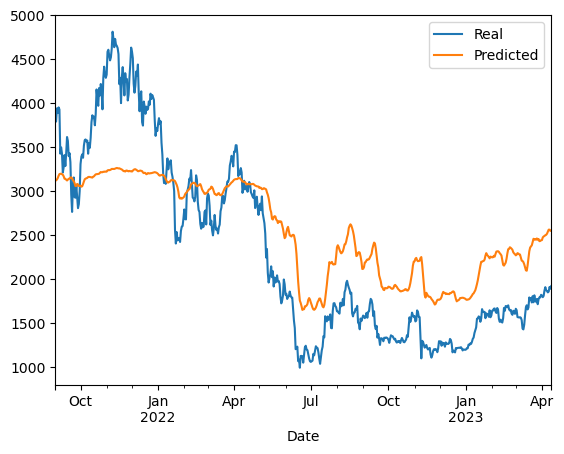

In [60]:
recommendation.plot()

In [61]:
#evluation metrics
mse = mean_squared_error(real_price, predicted_price)
rmse = mean_squared_error(real_price, predicted_price, squared=False)
mae = mean_absolute_error(real_price, predicted_price)
r2 = r2_score(real_price, predicted_price)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 402281.98085407563
Root Mean Squared Error: 634.2570305909708
Mean Absolute Error: 565.8548319740489
R-squared: 0.6349025530339201
